<a href="https://colab.research.google.com/github/allansdefreitas/unsupervised-learning/blob/main/FUZZY2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
"""Read:
https://sites.google.com/site/dataclusteringalgorithms/fuzzy-c-means-clustering-algorithm
https://towardsdatascience.com/fuzzy-c-means-clustering-with-python-f4908c714081
https://github.com/theimageprocessingguy/Fuzzy-C-Means-Python


https://pyclustering.github.io/docs/0.10.1/html/
https://scikit-fuzzy.github.io/scikit-fuzzy/
https://www.youtube.com/watch?v=nGWmgHxIoPk&ab_channel=%E6%9D%8E%E6%94%BF%E8%BB%92
https://www.youtube.com/watch?v=zEYxTGDYWYI

"""

'Read:\nhttps://sites.google.com/site/dataclusteringalgorithms/fuzzy-c-means-clustering-algorithm\nhttps://towardsdatascience.com/fuzzy-c-means-clustering-with-python-f4908c714081\nhttps://github.com/theimageprocessingguy/Fuzzy-C-Means-Python\n\n\nhttps://pyclustering.github.io/docs/0.10.1/html/\nhttps://scikit-fuzzy.github.io/scikit-fuzzy/\nhttps://www.youtube.com/watch?v=nGWmgHxIoPk&ab_channel=%E6%9D%8E%E6%94%BF%E8%BB%92\nhttps://www.youtube.com/watch?v=zEYxTGDYWYI\n\n'

In [3]:
!pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894073 sha256=333c1a12fdc6d0c54ae305966f695a6c5bec852c10eb130d476ed65944605a14
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [133]:
def initialize_membership_matrix(n_samples, n_clusters):
    """
    Initializes the membership matrix for Fuzzy C-Means.

    Parameters:
        n_samples (int): Number of data points.
        n_clusters (int): Number of clusters.

    Returns:
        numpy.ndarray: Initial membership matrix.
    """
    membership_matrix = np.random.rand(n_samples, n_clusters)
    membership_matrix /= np.sum(membership_matrix, axis=1, keepdims=True)
    return membership_matrix


def update_membership_matrix(data, centroids, m, distance_metric):
    """
    Updates the membership matrix for Fuzzy C-Means.

    Parameters:
        data (numpy.ndarray): Input data points.
        centroids (numpy.ndarray): Current centroid positions.
        m (float): Fuzziness parameter.
        distance_metric (str): Distance metric to use ('cityblock' or 'euclidean').

    Returns:
        numpy.ndarray: Updated membership matrix.
    """
    n_samples, n_clusters = data.shape[0], centroids.shape[0]
    membership_matrix = np.zeros((n_samples, n_clusters))

    for i in range(n_samples):
        for j in range(n_clusters):
            if distance_metric == 'cityblock':
                dist = np.sum(np.abs(data[i] - centroids[j]))
            elif distance_metric == 'euclidean':
                dist = np.linalg.norm(data[i] - centroids[j])
            else:
                raise ValueError("Invalid distance metric.")

            membership_matrix[i, j] = 1 / np.sum((dist / np.abs(data[i] - centroids)) ** (2 / (m - 1)))

    membership_matrix /= np.sum(membership_matrix, axis=1, keepdims=True)
    return membership_matrix


def update_centroids(data, membership_matrix, m):
    """
    Updates the centroids for Fuzzy C-Means.

    Parameters:
        data (numpy.ndarray): Input data points.
        membership_matrix (numpy.ndarray): Current membership matrix.
        m (float): Fuzziness parameter.

    Returns:
        numpy.ndarray: Updated centroid positions.
    """
    n_clusters, n_features = membership_matrix.shape[1], data.shape[1]
    centroids = np.zeros((n_clusters, n_features))

    for j in range(n_clusters):
        membership_power = membership_matrix[:, j] ** m
        centroids[j] = np.sum(membership_power.reshape(-1, 1) * data, axis=0) / np.sum(membership_power)

    return centroids



def fuzzy_cmeans(data, n_clusters_C, m, error_e=1e-6, max_iter=100, tolerance=1e-4, distance_metric='cityblock'):
    
    """
    Fuzzy C-Means clustering algorithm.

    Parameters:
        data (numpy.ndarray): Input data points.
        n_clusters (int): Number of clusters.
        m (float): Fuzziness parameter (> 1).
        distance_metric (str): Distance metric to use ('cityblock' or 'euclidean').
        max_iter (int): Maximum number of iterations.
        error_e (float): Convergence tolerance.

    Returns:
        numpy.ndarray: Final centroid positions.
        numpy.ndarray: Membership matrix.
        int: Number of iterations performed.
    """
    n_samples, n_features = data.shape
    membership_matrix = initialize_membership_matrix(n_samples, n_clusters_C)
    centroids = np.zeros((n_clusters_C, n_features))

    for iteration in range(max_iter):
        prev_centroids = centroids.copy()

        centroids = update_centroids(data, membership_matrix, m)
        membership_matrix = update_membership_matrix(data, centroids, m, distance_metric)

        if np.linalg.norm(centroids - prev_centroids) < error_e:
            break

    #transpose the U membership matrix 
    return centroids, membership_matrix.T, iteration+1

In [119]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from numpy import savetxt
from numpy import loadtxt
from sklearn.metrics import adjusted_rand_score
from sklearn import metrics
from sklearn import preprocessing
import skfuzzy as fuzz
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score

def preprocess_dataset(dataframe):

    #pre-processing of dataset
    scaler = StandardScaler()
    data = scaler.fit_transform(dataframe.values)
    
    return data

#VERIFY
def calculate_objective(data, centroids, membership_matrix, m, distance_metric='cityblock'):
    """
    Calculates the objective function value for Fuzzy C-Means.

    Parameters:
        data (numpy.ndarray): Input data points.
        centroids (numpy.ndarray): Current centroid positions.
        membership_matrix (numpy.ndarray): Current membership matrix.
        m (float): Fuzziness parameter.
        distance_metric (str): Distance metric to use ('cityblock' or 'euclidean').

    Returns:
        float: Objective function value.
    """

    data = data.T
    centroids = centroids.T
    membership_matrix = membership_matrix.T
    
    objective = 0
    n_samples, n_clusters = data.shape[0], centroids.shape[0]
    #É preciso obter a matriz transposta, já que aqui temos matriz de shape (num_grupos, num_elementos)
    #e o método espera o oposto disso. 
    membership_matrix = membership_matrix
    print(membership_matrix.shape)
    
    for i in range(n_samples):
        for j in range(n_clusters):
            if distance_metric == 'cityblock':
                #print(data[i].shape)
                #print("\ncent:")
                #print(centroids[j].shape)

                dist = np.sum(np.abs(data[i] - centroids[j]))

            objective += (membership_matrix[i, j] ** m) * (dist ** 2)

    return objective

#Modified partition coefficient e partition entropy --------------################


#close to 1 values are better
#A value of 0 indicates complete fuzziness, where data points have equal membership to all clusters
#A value of 1 indicates crisp or hard clustering, where data points have membership to only one cluster.
#VERIFY
def calculate_mpc(membership_matrix):
    """
    Calculates the Modified Partition Coefficient (MPC) for Fuzzy C-Means clustering.

    Parameters:
        membership_matrix (numpy.ndarray): Membership matrix of shape (n_samples, n_clusters).

    Returns:
        float: Modified Partition Coefficient value.
    """
    max_memberships = np.max(membership_matrix, axis=1)
    sum_memberships = np.sum(membership_matrix, axis=1)

    mpc = np.mean(max_memberships / sum_memberships)

    return mpc

#close to 0 values are better
#A value of 0 indicates a crisp or hard clustering, where data points have membership only to one cluster and there is no uncertainty
#higher values indicates uncertainty and fuzziness in the clustering, with data points having more equal memberships across multiple clusters.
#VERIFY
def calculate_partition_entropy(membership_matrix):
    """
    Calculates the Partition Entropy for Fuzzy C-Means clustering.

    Parameters:
        membership_matrix (numpy.ndarray): Membership matrix of shape (n_samples, n_clusters).

    Returns:
        float: Partition Entropy value.
    """
    n_samples, n_clusters = membership_matrix.shape
    entropy = 0.0

    for i in range(n_samples):
        for j in range(n_clusters):
            if membership_matrix[i, j] > 0:
                entropy -= membership_matrix[i, j] * np.log2(membership_matrix[i, j])

    partition_entropy = entropy / n_samples

    return partition_entropy


"""## Em cada dataset execute o algoritmo FCM com a distância de City-Block 50 vezes para obter 
uma partição fuzzy em 7 grupos e selecione o melhor resultado segundo a função objetivo."""
def get_best_partition(data, n_clusters_C, m, error_e, maxiter_T, distance_metric = 'cityblock', times_to_run=50):
    
    best_objective_value = 99999999999.9
    best_results = 0
    TIMES = times_to_run
    
    for i in range(TIMES):
    
      # Example usage
      #print("FCM: ", i + 1)
    
      #centroids, membership_matrix, iterations = fuzzy_cmeans(data, n_clusters, m, distance_metric)
      
      cntr, u, u0, d, jm, p, fpc = skfuzzy_fcm(data, n_clusters_C, m, error_e, maxiter_T, distance_metric)
      
      centroids, membership_matrix_U, iterations, objective_functions = cntr, u, p, jm
     
      objective_value = jm[-1] #the last element is the last and best objective function
      
      if(objective_value < best_objective_value):

        best_objective_value = objective_value
      
        best_results = centroids, membership_matrix_U, iterations, best_objective_value
    
    return best_results

#VERIFY
def fuzzy_to_crisp_partition(membership_matrix):
    """
    Converts a fuzzy partition into a crisp partition.

    Parameters:
        membership_matrix (numpy.ndarray): Membership matrix of shape (n_samples, n_clusters).

    Returns:
        numpy.ndarray: Crisp partition of shape (n_samples,).
    """
    crisp_partition = np.argmax(membership_matrix, axis=1)

    return crisp_partition

#from [-1, 1]. -1 better
#VERIFY
def calculate_ari(clustering_1, clustering_2):

  # Calculate ARI
  ari = adjusted_rand_score(clustering_1, clustering_2)

  return ari

#from [0,1]. 1 is better
#VERIFY
def calculate_f_measure(partition1, partition2):
    tp = sum(1 for i in partition1 for j in partition2 if i == j)  # Conta os verdadeiros positivos
    fp = len(partition1) - tp  # Calcula os falsos positivos
    fn = len(partition2) - tp  # Calcula os falsos negativos

    f_measure = (2 * tp) / (2 * tp + fp + fn)
    return f_measure

#from:
#https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.cluster.html
def skfuzzy_fcm(data, n_clusters_C, m,  error_e=0.000001, maxiter_T=100, distance_metric='cityblock'):

  #É preciso obter a matriz transposta, já que o método espera uma
  #matriz de shape (S, N), i.e. (num_grupos, num_elementos)
  # print(data.shape)
  data = data.T
  # print(data.shape)
  #data_city_block = cdist(data, data, metric='euclidean') #cityblock, euclidean, cosine #IS THIS RIGHT?
  #print(data_city_block, data_city_block.shape)

  # Perform Fuzzy C-means clustering
  cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
      data, #IT WAS: data_city_block.T. Is this right?  
      n_clusters_C,
      m=m,
      error=error_e,
      maxiter=maxiter_T
  )

  # The 'u' matrix contains the fuzzy membership values for each data point
  return  cntr, u, u0, d, jm, p, fpc

In [52]:
"""
I. Considere os dados "Image Segmentation" do site uci machine learning
repository (https://archive.ics.uci.edu/ml/datasets/Image+Segmentation).

"""

NUMBER_OF_DATASETS = 3

PATH = 'https://raw.githubusercontent.com/allansdefreitas/unsupervised-learning/main/segmentation.data'
PATH2 = 'https://raw.githubusercontent.com/allansdefreitas/unsupervised-learning/main/segmentation.test'

dataset_original = pd.read_csv(PATH, sep=',')
dataset_original2 = pd.read_csv(PATH2, sep=',')

#concat datasets
frames = [dataset_original, dataset_original2]
dataset_original_indexes = pd.concat(frames)

dataset_original = dataset_original_indexes.reset_index(drop=True)

indexes = dataset_original_indexes.index

#obter os labels a priori
indexes = dataset_original_indexes.index
indexes_label = []

for i in indexes:
    indexes_label.append(i)

le = preprocessing.LabelEncoder()
labels_a_priori = le.fit_transform(indexes_label)


""" Considere 3 datasets: """
""" 1) primeiro considerando as variáveis 4 a 9 (shape) ----------"""

dataset_1 = dataset_original.iloc[:,3:9]
#pre-processing of dataset
X_dataset_1 = preprocess_dataset(dataset_1)


"""2) o segundo considerando as variaveis 10 a 19 (rgb) ----------"""
dataset_2 = dataset_original.iloc[:,9:19]
#pre-processing of dataset
X_dataset_2 = preprocess_dataset(dataset_2)

"""3) O terceiro considerando as variaveis 4 a 19 (shape + rgb) -------"""
dataset_3 = dataset_original.iloc[:,3:19]
#pre-processing of dataset
X_dataset_3 = preprocess_dataset(dataset_3)


""" Em cada dataset execute o algoritmo FCM com a distância de City-Block
50 vezes para obter uma partição fuzzy em 7 grupos e selecione o melhor
resultado segundo a função objetivo. """

' Em cada dataset execute o algoritmo FCM com a distância de City-Block\n50 vezes para obter uma partição fuzzy em 7 grupos e selecione o melhor\nresultado segundo a função objetivo. '

test pyclustering

In [53]:
labels_a_priori, np.unique(labels_a_priori)

(array([0, 0, 0, ..., 1, 1, 1]), array([0, 1, 2, 3, 4, 5, 6]))

In [138]:
#data = X_dataset_1
n_clusters_C = 7
m = 1.1 #{1.1; 1.6; 2.0}. 1.1 resuls on error: RuntimeWarning: overflow encountered in exp AND invalid value encountered in true_divide. USE OTHER IMPL OF FCM
error_e = 0.000001
maxiter_T = 100
distance_metric = 'cityblock'
best_objective_value = 99999999999.9
best_results = 0
times = 1 #50


datasets = [X_dataset_1, X_dataset_2, X_dataset_3]
best_results = []

for dataset_i in datasets:
  #print(dataset_i)
  #print(dataset_i.shape)
  
  #centroids, U, iter = get_best_partition(dataset_i, n_clusters, m, distance_metric = 'cityblock', times_to_run=times)
  centroids, U, iter, objective_value = get_best_partition(dataset_i, n_clusters_C, m, error_e, maxiter_T, distance_metric = 'cityblock', times_to_run=times)
  best_results.append([centroids, U, iter, objective_value])
  
  # print(U)
  #print("\n\n\n", U.shape, "\n\n\n")

#Salvar melhores matrizes de grau de associação (U) como arquivos csv

#save datasets to csv files ---------------------##
#get the centroids, too?
for i in range(NUMBER_OF_DATASETS):
  membership_matrix_U = best_results[i][1] #i-th membership_matrix

  # save i-th dataset to csv file
  filename = 'dataset_'+ str(i + 1) + '_U_matrix'
  savetxt(filename + '.csv', membership_matrix_U, delimiter=',')

#load datasets from csv files --------------------##
membership_matrixes = []

for i in range(NUMBER_OF_DATASETS):

  # save i-th dataset to csv file
  filename = 'dataset_'+ str(i + 1) + '_U_matrix'
  membership_matrix = loadtxt(filename + '.csv', delimiter=',') #recover #i-th membership_matrix
  membership_matrixes.append(membership_matrix)

In [139]:
type(datasets), len(datasets), type(datasets[0]), datasets[0].shape

(list, 3, numpy.ndarray, (2310, 6))

In [140]:
type(membership_matrixes), len(membership_matrixes), membership_matrixes[0].shape

(list, 3, (7, 2310))

In [141]:
membership_matrixes[2].shape

(7, 2310)

In [147]:
#get clusters (labels) for each dataset

labels_cluster_posteriori = []
accuracies_datasets = []

for U in membership_matrixes:

  labels = np.argmax(U, axis=0)
  labels_cluster_posteriori.append(labels)

  #get accuracy score
  acc_dataset_i = accuracy_score(labels, labels_a_priori)
  accuracies_datasets.append(acc_dataset_i)

In [148]:
accuracies_datasets

[0.15627705627705626, 0.005627705627705628, 0.047186147186147186]

In [1]:
#testes

In [ ]:
#fim testes

In [ ]:
"""Para cada dataset e partição fuzzy, calcule o Modified partition coefficient
e o Partition entropy. (OK. verificar) Comente"""

#Obtendo Modified partition coefficient e partition entropy para cada dataset

mpc_and_partition_entropies = []

for ith_mem_matrix in membership_matrixes:

  mpc = calculate_mpc(ith_mem_matrix)
  partition_entropy = calculate_partition_entropy(ith_mem_matrix)

  mpc_and_partition_entropies.append( [mpc, partition_entropy] )

In [ ]:
mpc_and_partition_entropies #It is CORRECT have values above 1 as partition entropy???

In [ ]:
""" Para cada dataset e partição fuzzy, produza uma partição CRISP em 7
grupos e calcule o índice de Rand corrigido, e a F-measure (adaptada
para agrupamento). Comente """


#obtendo partiçoes CRISP
crisp_partitions = []

for i in range(NUMBER_OF_DATASETS):

  crisp = fuzzy_to_crisp_partition(membership_matrixes[i])
  crisp_partitions.append(crisp)


#Obtendo ARI

In [ ]:
crisp_partitions, crisp_partitions[0].shape, np.unique(crisp_partitions[0])

In [ ]:
#test
e = 2001
sum = 0
for i in range(NUMBER_OF_DATASETS):

  sum += membership_matrixes[0][e][i]

sum

In [ ]:
labels_a_priori.shape, crisp_partitions[0].shape

In [ ]:
"""Para cada dataset e partição fuzzy, calcule o índice de Rand corrigido, 
e a F-measure (adaptada para agrupamento Comente"""

#Obtendo Índice de range corrigido e f-measure para cada partição CRISP

rand_index_f_measures = []

for ith_crisp_partition in crisp_partitions:

  clustering_rand_index = calculate_ari(ith_crisp_partition, labels_a_priori)
  f_measure = calculate_f_measure(ith_crisp_partition, labels_a_priori)

  rand_index_f_measures.append( [clustering_rand_index, f_measure] )

In [ ]:
rand_index_f_measures

In [ ]:
np.unique(crisp)

#entender via video aula etc sobre a aplicação do indice de rand corrigido e f-measure

In [ ]:
#data = X_dataset_1
n_clusters_C = 7
m = 2 #{1.1; 1.6; 2.0}. 1.1 resuls on error: RuntimeWarning: overflow encountered in exp AND invalid value encountered in true_divide. USE OTHER IMPL OF FCM
distance_metric = 'cityblock'
error_e=0.000001
maxiter_T=100
best_objective_value = 99999999999.9
best_results = 0
times = 1 #50



datasets = [X_dataset_1, X_dataset_2, X_dataset_3]

In [ ]:
# centroids, U, iter = fuzzy_cmeans(X_dataset_1, n_clusters_C, m, distance_metric = 'cityblock')

cntr, u, u0, d, jm, p, fpc = skfuzzy_fcm(X_dataset_1.T, n_clusters_C, m, error_e, maxiter_T, distance_metric)
centroids2, U, iter2, objective_functions = cntr, u, p, jm
U

array([[2.06280545e-05, 2.35547722e-05, 1.57612622e-05, ...,
        1.14318957e-05, 3.97035943e-05, 2.20067322e-05],
       [9.40058122e-01, 9.31976490e-01, 9.53774285e-01, ...,
        9.67438531e-01, 7.95028410e-01, 9.03237632e-03],
       [3.26840511e-04, 3.73654227e-04, 2.49122895e-04, ...,
        1.79491867e-04, 6.26718439e-04, 4.23619458e-04],
       ...,
       [5.96964851e-05, 6.81867689e-05, 4.55841763e-05, ...,
        3.30092573e-05, 1.14706393e-04, 6.66731075e-05],
       [2.24047863e-03, 2.56614766e-03, 1.70102796e-03, ...,
        1.21000974e-03, 4.32881258e-03, 4.20356337e-03],
       [4.89192630e-02, 5.54016967e-02, 3.78579727e-02, ...,
        2.66461916e-02, 1.83363932e-01, 1.24619265e-02]])

In [ ]:
U[:,0], U.shape

(array([2.06280545e-05, 9.40058122e-01, 3.26840511e-04, 8.37497091e-03,
        5.96964851e-05, 2.24047863e-03, 4.89192630e-02]),
 (7, 2310))

In [ ]:
#verificando validade do cálculo. OK
C = 7
sum = 0
for i in range(C):

  sum += U[i][0]

sum

0.9999999999999999

In [ ]:
preds = U.argmax(axis=0)
preds

array([1, 1, 1, ..., 1, 1, 3])

In [ ]:
np.unique(preds)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
#https://www.youtube.com/watch?v=zEYxTGDYWYI
#MORE ON: https://scikit-fuzzy.readthedocs.io/en/latest/auto_examples/plot_cmeans.html

Text(0.5, 1.0, 'Test data: 200 points x3 clusters.')

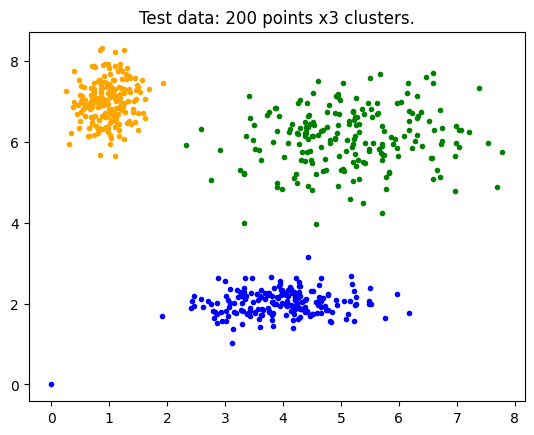

In [ ]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define three cluster centers
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

# Generate test data
np.random.seed(42)  # Set seed for reproducibility
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))

# Visualize the test data
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Test data: 200 points x3 clusters.')

In [ ]:
alldata.shape

(2, 601)

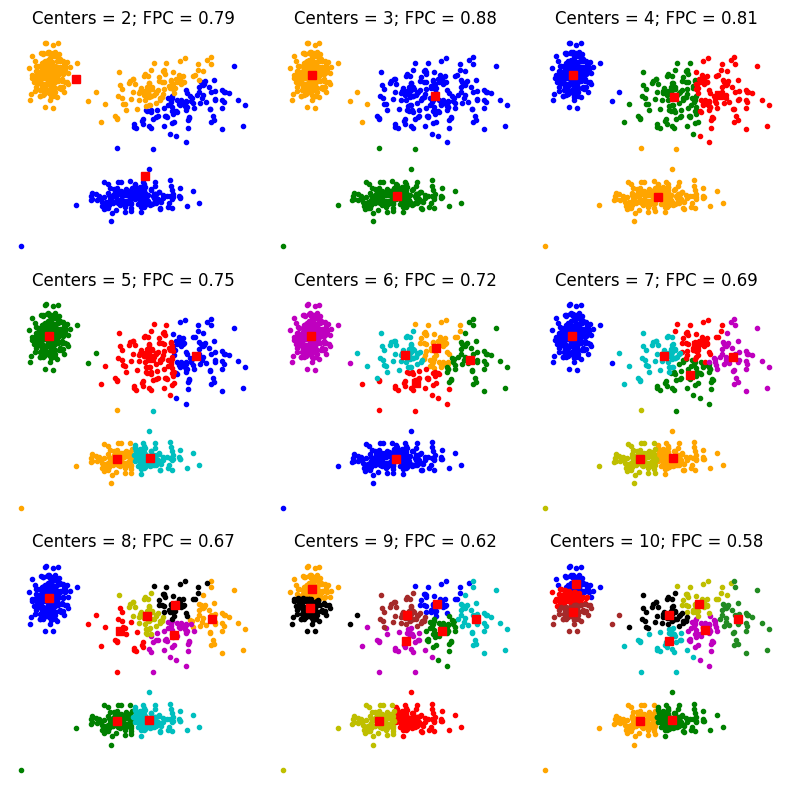

In [ ]:
# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

In [ ]:
#objective_value = calculate_objective(X_dataset_1, centroids, U, m, distance_metric)
objective_value = calculate_objective(X_dataset_1.T, centroids, U, m, distance_metric)
objective_value

25280882098.757973

In [ ]:
X_dataset_1.T.shape

(6, 2310)

In [ ]:
import numpy as np
import skfuzzy as fuzz
from scipy.spatial.distance import cdist

# Generate some random data
#data = np.random.rand(100, 2)

# Set the number of clusters
num_clusters = 3

# Apply city-block (Manhattan) distance effect
data_city_block = cdist(data, data, metric='cityblock') #euclidean, cosine

# Perform Fuzzy C-means clustering
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    data_city_block.T,
    num_clusters,
    2,
    error=0.005,
    maxiter=1000
)

# The 'u' matrix contains the fuzzy membership values for each data point

# Print the cluster centers
print("Cluster centers:")
print(cntr)

# Print the fuzzy membership values for the first data point
print("Fuzzy membership values for data point 0:")
print(u[:, 0])


NameError: ignored

In [ ]:

import numpy as np
import skfuzzy as fuzz
from scipy.spatial.distance import cdist

# Set the random seed for reproducibility
RANDOM_SEED=42

np.random.seed(RANDOM_SEED)

# Generate some random data
data = np.random.rand(100, 2)

# Set the number of clusters
num_clusters = 3

# Apply city-block (Manhattan) distance effect
data_city_block = cdist(data, data, metric='cityblock') #cityblock, euclidean, cosine

# Set the random seed for numpy.random
np.random.seed(RANDOM_SEED)

# Perform Fuzzy C-means clustering
# cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_city_block.T,
    num_clusters,
    m=2,
    error=0.005,
    maxiter=1000
)

# The 'u' matrix contains the fuzzy membership values for each data point

return_func = cntr, u, p

# Print the cluster centers
print("Cluster centers:")
print(cntr)

# Print the fuzzy membership values for the first data point
print("Fuzzy membership values for data point 0:")
print(u[:, 0])



Cluster centers:
[[0.46274456 0.75777519 0.71170071 0.3173019  0.59533432 0.40334486
  1.17680507 0.69197533 0.43603768 0.73302008 1.03825065 0.56448648
  0.46288232 0.39714362 1.11227761 1.00410148 0.36134106 0.94340684
  0.82645236 0.82636793 0.39430948 0.35070899 0.33772505 0.44354712
  0.93513976 0.94497804 0.94836825 0.63863048 0.66927325 0.56273573
  0.71568179 1.0384653  0.41136274 0.28935776 0.39059057 1.13204627
  0.33643759 0.6914097  1.2528815  0.84243683 0.87098632 0.87662922
  0.61268292 0.73600093 0.99252549 0.28753253 0.80688579 0.861802
  0.68908145 0.78302805 0.33508691 0.45321262 1.21438925 0.42321912
  0.80971397 0.75573571 0.90786936 0.64468608 1.17377868 0.94699828
  0.82093661 0.82241337 0.47986967 0.81534662 0.4276768  0.78591828
  0.53380666 1.17974913 0.52215643 0.47166909 1.26593292 0.78099598
  0.87543229 0.70266024 0.60314948 1.22429512 0.40209831 1.29826657
  0.65826377 0.31517851 0.41513607 0.70221339 0.29649296 0.74974813
  0.35231497 1.22125121 0.8642175

In [ ]:
u.shape 

(3, 100)

In [ ]:
u

array([[0.75254085, 0.05736299, 0.16637424, 0.84119102, 0.2004429 ,
        0.71950683, 0.1203089 , 0.13376998, 0.40460008, 0.05467584,
        0.09568886, 0.1543952 , 0.50995925, 0.53999792, 0.1058772 ,
        0.09335675, 0.77302923, 0.16326376, 0.07120192, 0.10912383,
        0.61282596, 0.78300243, 0.73793073, 0.38761196, 0.0705007 ,
        0.14337184, 0.2039697 , 0.31915359, 0.23050239, 0.36244086,
        0.04152024, 0.08994081, 0.46966905, 0.94171726, 0.74780404,
        0.11826266, 0.84323755, 0.09783099, 0.13484961, 0.04213906,
        0.02923339, 0.07393312, 0.09864896, 0.05957111, 0.0489383 ,
        0.94856102, 0.04794493, 0.06096765, 0.15806333, 0.29055179,
        0.90431859, 0.36519349, 0.12080594, 0.58009687, 0.13290467,
        0.0568822 , 0.1477413 , 0.24367536, 0.12185575, 0.03398951,
        0.17418598, 0.0599141 , 0.3174435 , 0.15145045, 0.72914277,
        0.02911474, 0.3025998 , 0.10691741, 0.32601439, 0.76563723,
        0.1287745 , 0.07717251, 0.11385485, 0.15

In [ ]:
u_T = u.T
u_T.shape

(100, 3)

In [ ]:
u_T

array([[0.75254085, 0.14616545, 0.1012937 ],
       [0.05736299, 0.87568479, 0.06695222],
       [0.16637424, 0.09033586, 0.7432899 ],
       [0.84119102, 0.07890625, 0.07990272],
       [0.2004429 , 0.6526624 , 0.1468947 ],
       [0.71950683, 0.14194741, 0.13854576],
       [0.1203089 , 0.51042907, 0.36926203],
       [0.13376998, 0.07543418, 0.79079585],
       [0.40460008, 0.17346598, 0.42193394],
       [0.05467584, 0.06457528, 0.88074888],
       [0.09568886, 0.21428846, 0.69002269],
       [0.1543952 , 0.09301122, 0.75259358],
       [0.50995925, 0.31984802, 0.17019274],
       [0.53999792, 0.1286878 , 0.33131428],
       [0.1058772 , 0.20715438, 0.68696842],
       [0.09335675, 0.21246615, 0.69417711],
       [0.77302923, 0.1145783 , 0.11239247],
       [0.16326376, 0.71775516, 0.11898108],
       [0.07120192, 0.05527976, 0.87351832],
       [0.10912383, 0.63546666, 0.25540951],
       [0.61282596, 0.10814601, 0.27902804],
       [0.78300243, 0.10901808, 0.10797949],
       [0.

In [ ]:
u_T[0][0] + u_T[0][1] + u_T[0][2] 

In [ ]:
#https://pyclustering.github.io/docs/0.10.1/html/d2/d6a/classpyclustering_1_1cluster_1_1fcm_1_1fcm.html

In [ ]:
!pip3 install pyclustering

In [ ]:
from pyclustering.samples.definitions import FAMOUS_SAMPLES
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.fcm import fcm
from pyclustering.utils import read_sample
 
# load list of points for cluster analysis
#sample = read_sample(FAMOUS_SAMPLES.SAMPLE_OLD_FAITHFUL)
sample = X_dataset_1
# initialize
initial_centers = kmeans_plusplus_initializer(sample, 7, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
 
# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(sample, initial_centers)
 
# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()
 
# visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.append_cluster(centers, marker='*', markersize=10)
visualizer.show()

In [ ]:
len(clusters), type(clusters), type(clusters[0])

(7, list, list)

In [ ]:
len(clusters[0])

1418

In [ ]:
len(centers), centers

(7,
 [[-0.35148703602318987,
   -0.18813989206146595,
   -0.31721273901483743,
   -0.10374354655326862,
   -0.3341774365710623,
   -0.11815496413506972],
  [-0.3498089368944582,
   3.37161070943518,
   7.300446669636318,
   11.590538753735483,
   8.1765080349457,
   12.41039951645139],
  [-0.0701586126340125,
   4.597679840924702,
   0.6557413917574577,
   0.1519166806881809,
   0.7235033387365539,
   0.10727904068638301],
  [-0.2874208667662181,
   -0.06151809354695918,
   0.5430312423368087,
   0.13386868734021756,
   2.434308761568129,
   0.8000709198608187],
  [-0.2781612425499423,
   1.001335240722827,
   5.427840597551387,
   3.0479088464082933,
   2.5616067132222136,
   1.5477533803154573],
  [-0.3362177809110667,
   -0.1680998938090753,
   0.49285925334943814,
   -0.019068412046779965,
   0.24821383641465536,
   -0.043053121236836585],
  [2.5117259010935338,
   -0.15776741987795834,
   -0.0032671378276564744,
   -0.060945410276421155,
   -0.039707812971794154,
   -0.08471871823

In [144]:
#verificar se soma de probabilidades para cada cluster resulta em 1
e = 1
sum = 0
for i in range(n_clusters_C):

  sum += membership_matrixes[0][i][e]

sum

1.0